<a href="https://colab.research.google.com/github/SeungHan0816/WM-811k_Wafermap_Practice/blob/main/WM_811k_Wafermap_DL_ENV2-S_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# EfficientNetV2-S 알고리즘 사용 (GPU 추천)

# [1단계] 필수 패키지 설치 + 임포트 + 장치 설정 + 데이터 로딩
# Colab에서 최초 1회 실행
!pip install kagglehub timm --quiet

import os, warnings, numpy as np, pandas as pd, torch
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import Normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import timm, kagglehub

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Device: {device}")

# 데이터셋 다운로드 및 로드
data_path = kagglehub.dataset_download('qingyi/wm811k-wafer-map')
raw = pd.read_pickle(os.path.join(data_path, "LSWMD.pkl"))
print(f"✅ Raw samples: {len(raw)}개")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.3 MB/s eta 0:00:00
✅ Device: cuda
✅ Raw samples: 811457개


In [2]:
# [2단계] 전처리 – failureType 추출 → 'none' 제거 → 라벨 매핑 → 이진화

# 문자열 안전 추출 함수
def safe_extract_failure_type(x):
    while isinstance(x, (list, np.ndarray)):
        if isinstance(x, np.ndarray) and x.shape == ():
            x = x.item()
            continue
        if len(x) == 0:
            return 'none'
        x = x[0]
    return x if isinstance(x, str) else str(x)

# failureType 문자열 추출
raw['failureType_str'] = raw['failureType'].apply(safe_extract_failure_type)

# 'none' 제거
df = raw[raw['failureType_str'] != 'none'].reset_index(drop=True)
print(f"🔹 유효 샘플 수: {len(df)}개")

# 라벨 매핑
label_map = {
    'Center':0, 'Donut':1, 'Edge-Loc':2, 'Edge-Ring':3,
    'Loc':4, 'Random':5, 'Scratch':6, 'Near-full':7
}
df['label'] = df['failureType_str'].map(label_map)

# 이진화 함수 (0/1로)
def binarize(x):
    a = np.array(x, np.float32)
    return (a == 1).astype(np.float32)

df['img'] = df['waferMap'].apply(binarize)
print("✅ 2단계 완료: img·label 컬럼 생성")


🔹 유효 샘플 수: 25519개
✅ 2단계 완료: img·label 컬럼 생성


In [3]:
# [3단계] 클래스 분포 확인 + 학습/검증 데이터 분할

# 역 라벨 매핑
reverse_map = {v: k for k, v in label_map.items()}

# 전체 클래스 분포 출력
total = len(df)
print(f"🔹 전체 샘플 수: {total}개")
for cls in sorted(reverse_map):
    cnt = (df['label'] == cls).sum()
    print(f"  클래스 {cls}({reverse_map[cls]}): {cnt}개 ({cnt / total * 100:.2f}%)")

# 학습 / 검증 셋 분할 (라벨 균형 유지)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 학습셋 분포 출력
train_total = len(train_df)
print(f"\n🟢 학습 데이터 수: {train_total}개")
for cls in sorted(reverse_map):
    cnt = (train_df['label'] == cls).sum()
    print(f"  클래스 {cls}: {cnt}개 ({cnt / train_total * 100:.2f}%)")

# 검증셋 분포 출력
val_total = len(val_df)
print(f"\n🔵 검증 데이터 수: {val_total}개")
for cls in sorted(reverse_map):
    cnt = (val_df['label'] == cls).sum()
    print(f"  클래스 {cls}: {cnt}개 ({cnt / val_total * 100:.2f}%)")


🔹 전체 샘플 수: 25519개
  클래스 0(Center): 4294개 (16.83%)
  클래스 1(Donut): 555개 (2.17%)
  클래스 2(Edge-Loc): 5189개 (20.33%)
  클래스 3(Edge-Ring): 9680개 (37.93%)
  클래스 4(Loc): 3593개 (14.08%)
  클래스 5(Random): 866개 (3.39%)
  클래스 6(Scratch): 1193개 (4.67%)
  클래스 7(Near-full): 149개 (0.58%)

🟢 학습 데이터 수: 20415개
  클래스 0: 3435개 (16.83%)
  클래스 1: 444개 (2.17%)
  클래스 2: 4151개 (20.33%)
  클래스 3: 7744개 (37.93%)
  클래스 4: 2874개 (14.08%)
  클래스 5: 693개 (3.39%)
  클래스 6: 955개 (4.68%)
  클래스 7: 119개 (0.58%)

🔵 검증 데이터 수: 5104개
  클래스 0: 859개 (16.83%)
  클래스 1: 111개 (2.17%)
  클래스 2: 1038개 (20.34%)
  클래스 3: 1936개 (37.93%)
  클래스 4: 719개 (14.09%)
  클래스 5: 173개 (3.39%)
  클래스 6: 238개 (4.66%)
  클래스 7: 30개 (0.59%)


In [4]:
# [4단계] 데이터 증강 + WaferDataset 정의 (224×224 + ImageNet 정규화)
# 이미지넷 정규화 기준
normalize = Normalize(mean=[0.485, 0.456, 0.406],
                      std =[0.229, 0.224, 0.225])

# 🔁 학습용 데이터 증강 정의
train_transform = transforms.Compose([
    transforms.ToTensor(),  # numpy → Tensor
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    normalize
])

# 검증용은 증강 없이 정규화만
val_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

# ✅ WaferDataset 클래스 정의
class WaferDataset(Dataset):
    def __init__(self, df, transform=None, size=(224, 224)):
        self.imgs = df['img'].values
        self.labs = df['label'].values.astype(int)
        self.transform = transform
        self.size = size

    def __len__(self):
        return len(self.labs)

    def __getitem__(self, idx):
        # (H, W) → (3, H, W)
        x = np.stack([self.imgs[idx]] * 3, axis=2)
        x = transforms.ToPILImage()(x)
        x = x.resize(self.size)
        if self.transform:
            x = self.transform(x)

        y = torch.tensor(self.labs[idx], dtype=torch.long)
        return x, y

print("✅ 4단계 완료: 데이터셋 클래스 정의 완료")


✅ 4단계 완료: 데이터셋 클래스 정의 완료


In [5]:
# [5단계] DataLoader 구성 (학습/검증용 배치로 나누기)
# 학습용 데이터로더
train_loader = DataLoader(
    WaferDataset(train_df, transform=train_transform),
    batch_size=32, shuffle=True, num_workers=2
)

# 검증용 데이터로더
val_loader = DataLoader(
    WaferDataset(val_df, transform=val_transform),
    batch_size=32, shuffle=False, num_workers=2
)

print("✅ 5단계 완료: DataLoader 구성 완료")


✅ 5단계 완료: DataLoader 구성 완료


In [6]:
# [6단계] EfficientNetV2-S 전체 언프리징 + 옵티마이저 + 스케줄러 설정
# EfficientNetV2-S 모델 불러오기 (사전 학습 가중치 포함)
model = timm.create_model(
    "tf_efficientnetv2_s_in21k",  # In21k로 더 풍부한 feature
    pretrained=True,
    num_classes=8,
    drop_rate=0.5  # Dropout으로 과적합 방지
).to(device)

# ✅ 전체 레이어 언프리징 (fine-tuning 전체 수행)
for name, param in model.named_parameters():
    param.requires_grad = True  # 전부 학습 가능하게 설정

# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저 (모든 파라미터 대상, 학습률 조금 더 낮게)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-4)

# 스케줄러: 검증 손실 줄어들면 학습률 감소
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2, verbose=True
)

print("✅ 6단계 완료: 모델·옵티마이저·스케줄러 설정 완료")


model.safetensors:   0%|          | 0.00/193M [00:00<?, ?B/s]

✅ 6단계 완료: 모델·옵티마이저·스케줄러 설정 완료


In [7]:
# [7단계] 훈련 루프 (EarlyStopping 포함, 저장 X)
EPOCHS = 20
best_val_acc = 0.0
patience = 5
wait = 0

for epoch in range(1, EPOCHS + 1):
    # 🔹 학습 단계
    model.train()
    t_loss, t_corr = 0.0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        t_loss += loss.item() * labels.size(0)
        t_corr += (out.argmax(1) == labels).sum().item()

    train_loss = t_loss / len(train_df)
    train_acc = t_corr / len(train_df) * 100

    # 🔵 검증 단계
    model.eval()
    v_loss, v_corr, v_cnt = 0.0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            v_loss += loss.item() * labels.size(0)
            v_corr += (out.argmax(1) == labels).sum().item()
            v_cnt += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())

    val_loss = v_loss / v_cnt
    val_acc = v_corr / v_cnt * 100
    scheduler.step(val_loss)

    print(f"[{epoch:02d}] 🔹 Train Loss: {train_loss:.4f} | Acc: {train_acc:.2f}%  ||  🔵 Val Loss: {val_loss:.4f} | Acc: {val_acc:.2f}%")

    # EarlyStopping 조건 체크
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        wait = 0
        print("✅ 성능 향상 → EarlyStopping 카운터 초기화")
    else:
        wait += 1
        print(f"⚠️ EarlyStopping 경고: {wait}/{patience} 회")
        if wait >= patience:
            print(f"⛔ EarlyStopping 작동! {epoch}번째 에포크에서 중단")
            break


[01] 🔹 Train Loss: 3.1588 | Acc: 57.31%  ||  🔵 Val Loss: 0.8432 | Acc: 72.94%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[02] 🔹 Train Loss: 0.7642 | Acc: 75.05%  ||  🔵 Val Loss: 0.4975 | Acc: 80.98%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[03] 🔹 Train Loss: 0.5034 | Acc: 82.42%  ||  🔵 Val Loss: 0.3619 | Acc: 86.17%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[04] 🔹 Train Loss: 0.3747 | Acc: 86.79%  ||  🔵 Val Loss: 0.3369 | Acc: 87.25%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[05] 🔹 Train Loss: 0.3092 | Acc: 89.19%  ||  🔵 Val Loss: 0.2601 | Acc: 90.24%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[06] 🔹 Train Loss: 0.2606 | Acc: 90.86%  ||  🔵 Val Loss: 0.2349 | Acc: 91.59%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[07] 🔹 Train Loss: 0.2342 | Acc: 91.65%  ||  🔵 Val Loss: 0.2653 | Acc: 90.56%
⚠️ EarlyStopping 경고: 1/5 회
[08] 🔹 Train Loss: 0.2209 | Acc: 92.15%  ||  🔵 Val Loss: 0.2235 | Acc: 92.22%
✅ 성능 향상 → EarlyStopping 카운터 초기화
[09] 🔹 Train Loss: 0.2045 | Acc: 92.82%  ||  🔵 Val Loss: 0.2190 | Acc: 91.97%
⚠️ EarlyStopping 경고: 1/5 회
[10] 🔹 Train Loss: 0

In [8]:
# [8단계] 최종 평가 (검증셋 전체 예측 결과 확인)
# 평가 모드 전환
model.eval()
y_true, y_pred = [], []

# 검증셋 전체에 대해 예측 수행
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        preds = out.argmax(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# 분류 리포트 출력
from sklearn.metrics import classification_report, confusion_matrix

print("\n🔎 Classification Report")
print(classification_report(y_true, y_pred, digits=4))



🔎 Classification Report
              precision    recall  f1-score   support

           0     0.9676    0.9721    0.9698       859
           1     0.8761    0.8919    0.8839       111
           2     0.9018    0.9027    0.9023      1038
           3     0.9556    0.9892    0.9721      1936
           4     0.9001    0.8526    0.8757       719
           5     0.9461    0.9133    0.9294       173
           6     0.9663    0.8445    0.9013       238
           7     1.0000    0.9667    0.9831        30

    accuracy                         0.9379      5104
   macro avg     0.9392    0.9166    0.9272      5104
weighted avg     0.9376    0.9379    0.9373      5104




📊 Confusion Matrix (Raw):
 [[ 835    3    3    9    8    1    0    0]
 [   5   99    1    1    5    0    0    0]
 [   1    0  937   71   25    3    1    0]
 [   1    0   16 1915    2    1    1    0]
 [  20    9   65    5  613    2    5    0]
 [   1    2    5    2    5  158    0    0]
 [   0    0   12    1   23    1  201    0]
 [   0    0    0    0    0    1    0   29]]

📊 Confusion Matrix (Normalized):
 [[0.972 0.003 0.003 0.01  0.009 0.001 0.    0.   ]
 [0.045 0.892 0.009 0.009 0.045 0.    0.    0.   ]
 [0.001 0.    0.903 0.068 0.024 0.003 0.001 0.   ]
 [0.001 0.    0.008 0.989 0.001 0.001 0.001 0.   ]
 [0.028 0.013 0.09  0.007 0.853 0.003 0.007 0.   ]
 [0.006 0.012 0.029 0.012 0.029 0.913 0.    0.   ]
 [0.    0.    0.05  0.004 0.097 0.004 0.845 0.   ]
 [0.    0.    0.    0.    0.    0.033 0.    0.967]]


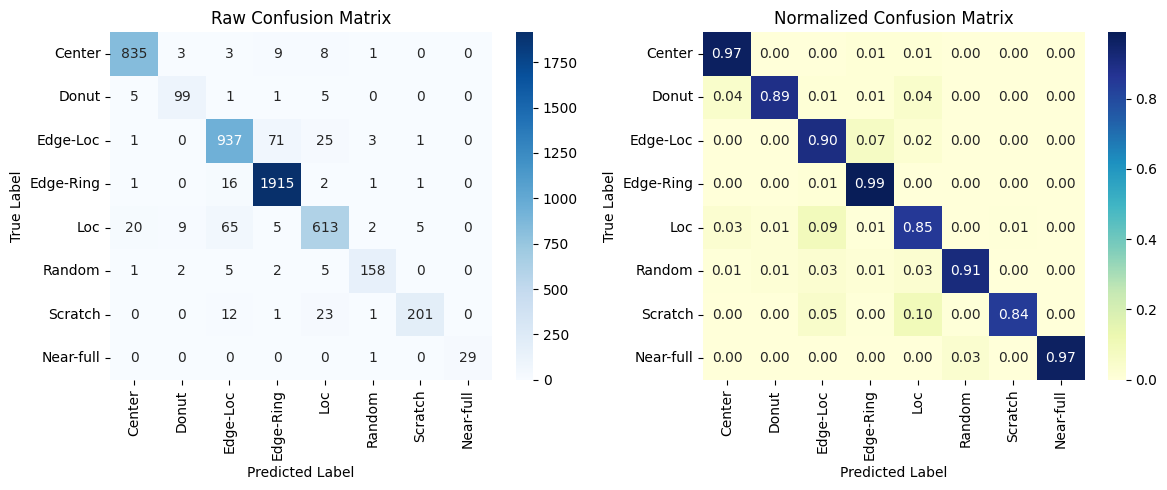

In [9]:
# [9단계] 혼동 행렬 시각화 (Raw + 정규화)
# 혼동 행렬 계산
cm = confusion_matrix(y_true, y_pred)
cm_norm = (cm.astype(float) / cm.sum(axis=1)[:, None]).round(3)

print("\n📊 Confusion Matrix (Raw):\n", cm)
print("\n📊 Confusion Matrix (Normalized):\n", cm_norm)

# 클래스 이름 리스트 (역매핑)
class_names = [reverse_map[i] for i in sorted(reverse_map)]

# 시각화
plt.figure(figsize=(12, 5))

# 🔵 원본 행렬
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Raw Confusion Matrix")
plt.xlabel("Predicted Label"); plt.ylabel("True Label")

# 🟢 정규화 행렬
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="YlGnBu",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label"); plt.ylabel("True Label")

plt.tight_layout()
plt.show()
